# Plot VEGAS Stage 6 Results

In [1]:
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table
import numpy as np
from scipy import stats

/Users/ning/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
spec_file = 'med_0p5off_GEO_stg6_spectrum_s6.fits'

In [3]:
rbm_file = 'med_0p5off_GEO_stg6_rbm_s6.fits'

In [4]:
log_file = 'med_0p5off_GEO_stg6_rbm.log'

## 1. Spectrum

In [5]:
def chi_sq_gof(energy,flux,error,normalization,index):
    x = energy.copy()
    y_o = flux.copy()
    y_e = normalization*x**index
    chi_sq = np.sum(np.divide((y_o-y_e)**2,error**2))
    p_val = 1 - stats.chi2.cdf(chi_sq, len(energy)-2)
    return chi_sq,p_val

def plot_spec(spec_file):
    spec = fits.getdata(spec_file,1,header=True)
    specFit = fits.getdata(spec_file,2,header=True)
    specCov = fits.getdata(spec_file,3,header=True)
    E = spec[0].Energy; F = spec[0].Flux; F_err = spec[0].FluxError
    sig = spec[0].Significance
    norm = specFit[0].Normalization[0]; ind = specFit[0].Index[0]
    chi_sq,p_val=chi_sq_gof(E,F,F_err,norm,ind)
    
    plt.rcParams.update({'font.size': 15})
    fig,ax = plt.subplots(1,2,figsize=(16,7))
    
    ax[0].errorbar(E,F,yerr=F_err,fmt='o',elinewidth=3,markersize=9)
    x = np.linspace(spec[0].EBinLowEdge[0],spec[0].EBinHiEdge[-1],100)
    y = norm*x**ind
    ax[0].plot(x,y,linewidth=3)
    ax[0].set_xscale('log')
    ax[0].set_yscale('log')
    ax[0].set_xlabel('Energy [TeV]')
    ax[0].set_ylabel(r"dN/dE [Te$V^{-1}$ m$^{-2}$ s$^{-1}$]")
    ax[0].set_title('Flux vs Energy')
    ax0_str = r'$\chi^2$ / dof = {:.4g} / {}'.format(chi_sq,len(spec[0].Energy)-2)
    ax0_str += '\nProb = {:.4g}\n'.format(p_val)
    ax0_str += r'Norm = {:.4g} $\pm$ {:.4g}'.format(norm,specFit[0].Normalization[1])
    ax0_str += '\n'
    ax0_str += r'Index = {:.4g} $\pm$ {:.4g}'.format(ind,specFit[0].Index[1])
    ax[0].annotate(ax0_str,
                   xy=(0.38,0.73),xycoords='axes fraction')
    
    ax[1].scatter(E,sig,s=75)
    ax[1].set_xscale('log')
    ax[1].set_xlabel('Energy [TeV]')
    ax[1].set_ylabel(r'Significance [$\sigma$]')
    ax[1].set_title('Significance vs Energy')
    ax[1].set_xlim(ax[0].get_xlim())
    ax1_str = r'MaxSig / E = {:.4g} / {:.4g}'.format(np.max(sig),E[np.argmax(sig)])
    ax1_str += '\n'
    ax1_str += r'MinSig / E = {:.4g} / {:.4g}'.format(np.min(sig),E[np.argmin(sig)])
    ax[1].annotate(ax1_str,xy=(0.43,0.77),xycoords='axes fraction')
    plt.show()

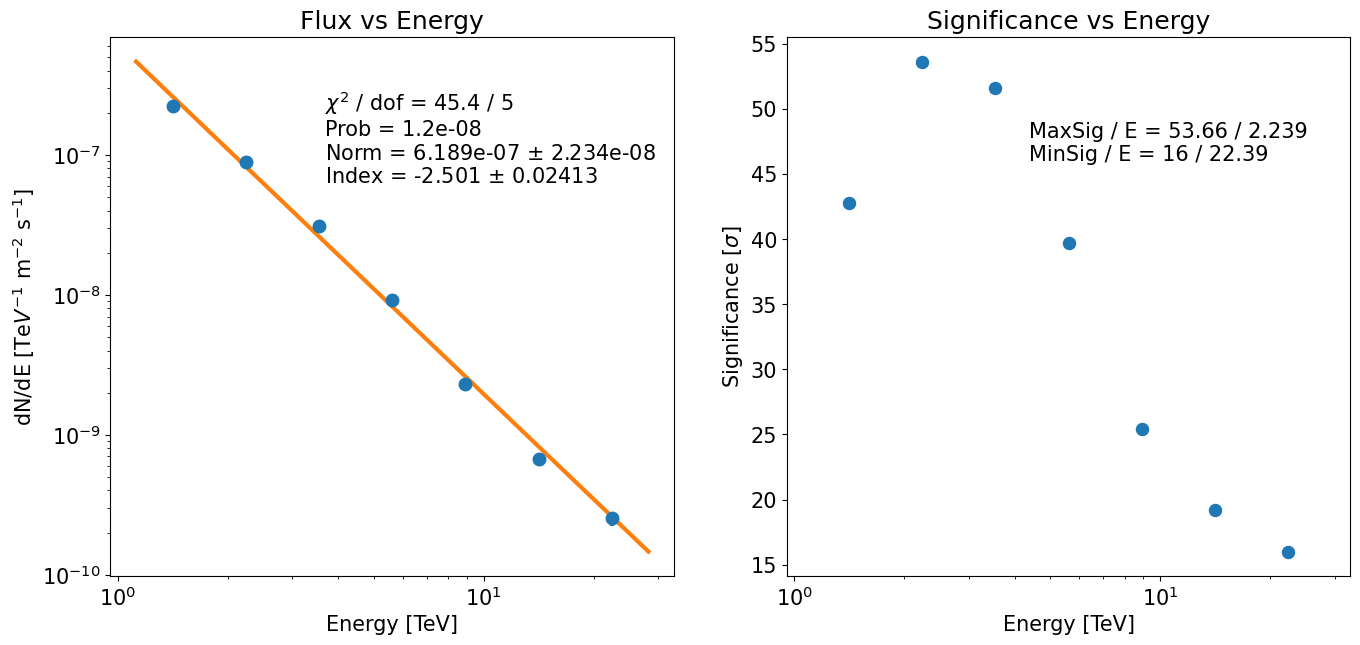

In [6]:
plot_spec(spec_file)

## 2. Sky Maps

In [7]:
def load_excl_region(log_file):
    xtable = Table()
    excl_str = '+++ RBM: Adding the sky map exclusion region :'
    with open(log_file,'r') as f:
        sources = []; RAs = []; DECs = []; rs = []
        for line in f:
            if excl_str in line:
                info = line.split(excl_str)[1]
                sources.append(info.split('RA')[0].strip())
                RAs.append(info.split(':')[1].split('DEC')[0].strip())
                DECs.append(info.split(':')[2].split('Radius')[0].strip())
                rs.append(info.split(':')[-1].strip())
    xtable['source'] = sources
    xtable['RA'] = RAs
    xtable['DEC'] = DECs
    xtable['r'] = rs
    return xtable

def plot_rbm(rbm_file,log_file):
    with fits.open(rbm_file) as d_sky:
        raw_excess_map = d_sky[1].data
        sig_map = d_sky[2].data
        sig_header = d_sky[2].header
        acceptance_map = d_sky[3].data
        raw_on_map = d_sky[4].data
        alpha_map = d_sky[5].data
        unc_excess_map = d_sky[6].data
        sig_distri = d_sky[7].data
        names = [d_sky[i+1].header['EXTNAME'] for i in range(7)]

    maps = [raw_excess_map,sig_map,acceptance_map,
            raw_on_map,alpha_map,unc_excess_map,sig_distri]
    xtab = load_excl_region(log_file)
    
    vec = range(216)
    x = [sig_header['CRVAL1']+(vec[i]+1-sig_header['CRPIX1'])*sig_header['CDELT1']
     for i in range(216)]
    y = [sig_header['CRVAL2']+(vec[i]+1-sig_header['CRPIX2'])*sig_header['CDELT2']
     for i in range(216)]
    X, Y = np.meshgrid(x, y)
    
    plt.rcParams.update({'font.size': 25})
    fig, axes = plt.subplots(2,3,figsize=(40,21))
    plt.subplots_adjust(wspace=0.4)
    for i in range(2):
        for j in range(3):
            ax = axes[i,j]
            m = maps[3*i+j]
            im = ax.contourf(X,Y,m,levels=1000)
            for k in range(len(xtab)):
                circ = plt.Circle((np.float64(xtab['RA'][k]),np.float64(xtab['DEC'][k])),
                                  np.float64(xtab['r'][k]),
                                  edgecolor='w',linewidth=2.5,fill=False)
                ax.add_patch(circ)
            ax.set_title(names[3*i+j])
            ax.set_xlim((min(x),max(x)))
            ax.set_ylim((min(y),max(y)))
            plt.colorbar(im,fraction=0.046, pad=0.04, ax=ax)
            ax.set_xlabel('RA [$^{\circ}$]'); ax.set_ylabel('DEC [$^{\circ}$]')
    plt.show()

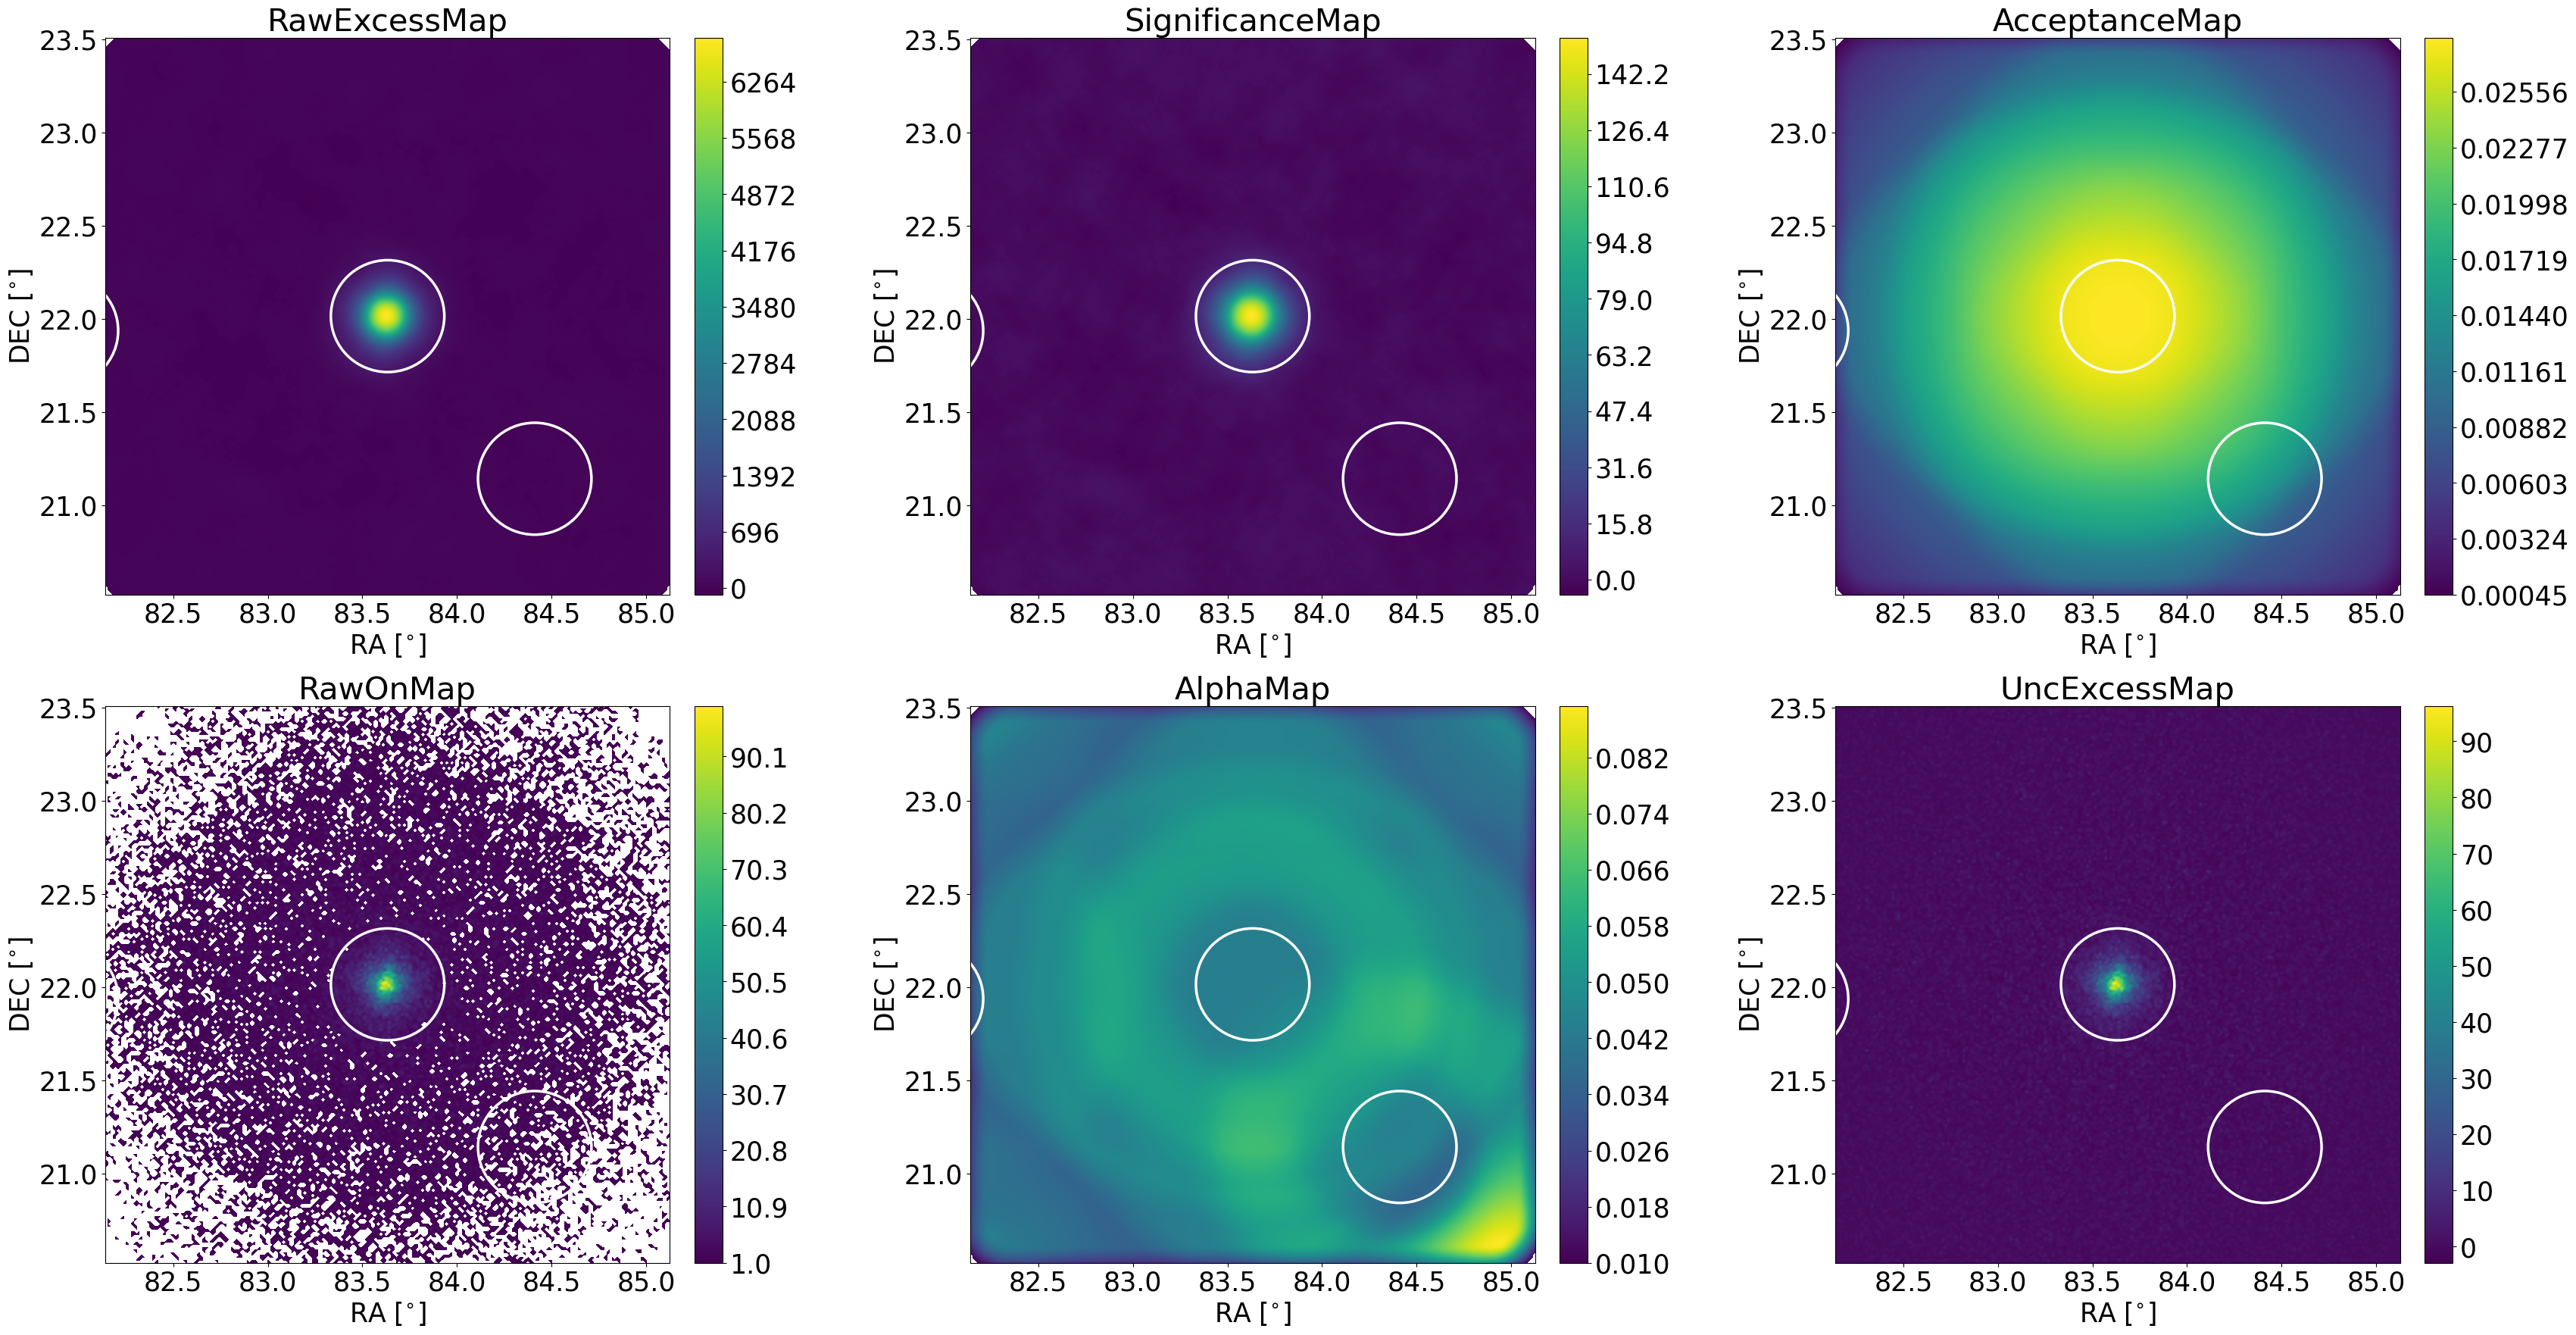

In [8]:
plot_rbm(rbm_file,log_file)